> (_Last run on 10/06/25_) This notebook demonstrates a generative climate model output emulator based on score-based diffusion models. The version shown here allows to run emulators of monthly averaged near-surface temperature, precipitation, relative humidity, wind speed for MPI-ESM1-2-LR. Full description of the methodology and evaluation are provided in the preprint.

### Setup collab on GPU

- From the dropdown menu, select Change runtime type.
<br>
<br>
<img src="https://github.com/shahineb/climemu/blob/main/examples/docs/1.jpg?raw=1" width="400" />

<br>

- In the Hardware accelerator section, select T4 GPU and click Save
<br>
<br>
<img src="https://github.com/shahineb/climemu/blob/main/examples/docs/2.jpg?raw=1" width="300" />

<br>

You can now start the session by running the next cell.

In [23]:
# Install package with GPU support
%%capture
!pip install climemu[cuda12] cartopy

In [24]:
# Import used dependencies
import climemu
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
import utils

In [25]:
# Instantiate emulator
emulator = climemu.build_emulator("MPI-ESM1-2-LR")

# Download pretrained weights and compile emulator (~1min)
emulator.load()
emulator.compile(n_samples=3)   # Nb of samples generated at each function call

In [26]:
# Choose GMST and month at which we emulate
gmst = 2       # GMST anomaly wrt piControl (°C)
month = 3      # Month index (1-12)

# Fix random seed for reproducibility
np.random.seed(42)

# Call the emulator e.g. 10 times
n_call = 10
samples = []
for _ in tqdm(range(n_call), desc=f"Emulating for ΔΤ = {gmst:.2f} °C for month {month}"):
  sample = emulator(gmst, month, xarray=True)
  samples.append(sample)

Emulating for ΔΤ = 2.00 °C for month 3:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
# Combine to form 3*10 = 30 emulated ensemble members
combined = xr.concat(samples, dim="member")
combined = combined.assign_coords(member=range(1, combined.sizes["member"] + 1))
combined

<xarray.Dataset> Size: 9MB
Dimensions:  (member: 30, lat: 96, lon: 192)
Coordinates:
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * member   (member) int64 240B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30
Data variables:
    tas      (member, lat, lon) float32 2MB ...
    pr       (member, lat, lon) float32 2MB ...
    hurs     (member, lat, lon) float32 2MB ...
    sfcWind  (member, lat, lon) float32 2MB ...

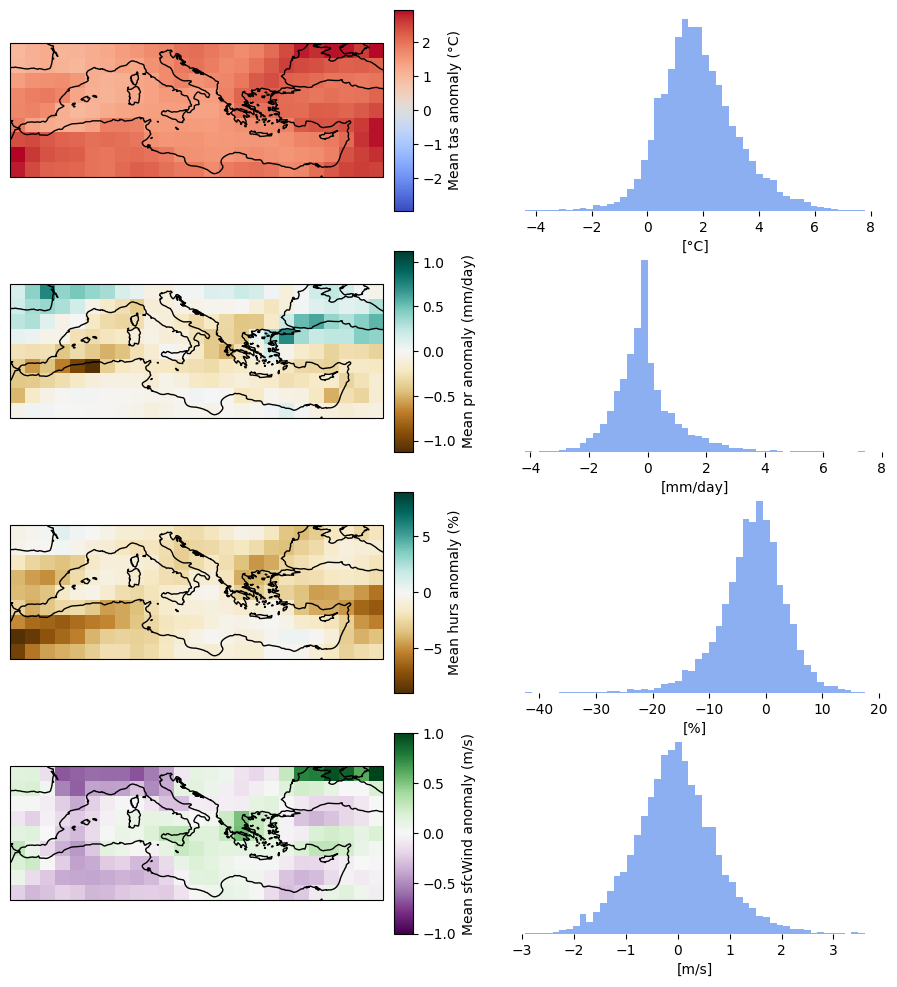

In [46]:
# Do your plots
# Here we zoom over the Mediterranean, plot the mean anomaly + distribution binned over grid cells and members

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import seaborn as sns


lon_range = slice(-7, 40)
lat_range = slice(30, 47)

lon360 = combined.lon.values
lon180 = ((lon360 + 180) % 360) - 180
combined180 = combined.assign_coords(lon=lon180).sortby("lon")

tas_ds = combined180['tas'].sel(lon=lon_range, lat=lat_range)
pr_ds = combined180['pr'].sel(lon=lon_range, lat=lat_range)
hurs_ds = combined180['hurs'].sel(lon=lon_range, lat=lat_range)
sfcWind_ds = combined180['sfcWind'].sel(lon=lon_range, lat=lat_range)

tas_data = tas_ds.values.ravel()
pr_data = pr_ds.values.ravel()
hurs_data = hurs_ds.values.ravel()
sfcWind_data = sfcWind_ds.values.ravel()

mean_tas = tas_ds.mean('member')
mean_pr = pr_ds.mean('member')
mean_hurs = hurs_ds.mean('member')
mean_sfcWind = sfcWind_ds.mean('member')

width_ratios  = [1, 0.05, 0.2, 1]
height_ratios = [1, 1, 1, 1]
nrow = len(height_ratios)
ncol = len(width_ratios)
nroweff = sum(height_ratios)
ncoleff = sum(width_ratios)

fig = plt.figure(figsize=(5 * ncoleff, 3 * nroweff))

gs = GridSpec(nrows=nrow,
          ncols=ncol,
          figure=fig,
          width_ratios=width_ratios,
          height_ratios=height_ratios,
          hspace=0.2,
          wspace=0.05)


ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
mesh = mean_tas.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)
ax.coastlines()
vmax = np.abs(mean_tas.values).max().item()
mesh.set_clim(-vmax, vmax)
cax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(mesh,
                  cax=cax,
                  orientation='vertical')
cbar.set_label(f"Mean tas anomaly (°C)", labelpad=4)

ax = fig.add_subplot(gs[0, 3])
sns.histplot(tas_data, ax=ax, kde=False, stat="density", bins=50, color="cornflowerblue", edgecolor=None)
ax.set_frame_on(False)
ax.yaxis.set_visible(False)
ax.set_xlabel("[°C]")


ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
mesh = mean_pr.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False)
ax.coastlines()
vmax = np.abs(mean_pr.values).max().item()
mesh.set_clim(-vmax, vmax)
cax = fig.add_subplot(gs[1, 1])
cbar = fig.colorbar(mesh,
                  cax=cax,
                  orientation='vertical')
cbar.set_label(f"Mean pr anomaly (mm/day)", labelpad=4)

ax = fig.add_subplot(gs[1, 3])
sns.histplot(pr_data, ax=ax, kde=False, stat="density", bins=50, color="cornflowerblue", edgecolor=None)
ax.set_frame_on(False)
ax.yaxis.set_visible(False)
ax.set_xlabel("[mm/day]")



ax = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
mesh = mean_hurs.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False)
ax.coastlines()
vmax = np.abs(mean_hurs.values).max().item()
mesh.set_clim(-vmax, vmax)
cax = fig.add_subplot(gs[2, 1])
cbar = fig.colorbar(mesh,
                  cax=cax,
                  orientation='vertical')
cbar.set_label(f"Mean hurs anomaly (%)", labelpad=4)

ax = fig.add_subplot(gs[2, 3])
sns.histplot(hurs_data, ax=ax, kde=False, stat="density", bins=50, color="cornflowerblue", edgecolor=None)
ax.set_frame_on(False)
ax.yaxis.set_visible(False)
ax.set_xlabel("[%]")


ax = fig.add_subplot(gs[3, 0], projection=ccrs.PlateCarree())
mesh = mean_sfcWind.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn', add_colorbar=False)
ax.coastlines()
vmax = np.abs(mean_sfcWind.values).max().item()
mesh.set_clim(-vmax, vmax)
cax = fig.add_subplot(gs[3, 1])
cbar = fig.colorbar(mesh,
                  cax=cax,
                  orientation='vertical')
cbar.set_label(f"Mean sfcWind anomaly (m/s)", labelpad=4)

ax = fig.add_subplot(gs[3, 3])
sns.histplot(sfcWind_data, ax=ax, kde=False, stat="density", bins=50, color="cornflowerblue", edgecolor=None)
ax.set_frame_on(False)
ax.yaxis.set_visible(False)
ax.set_xlabel("[m/s]")
plt.show()